In [1]:
import numpy as np
from copy import deepcopy
import scipy.sparse as sp
from scipy.stats import poisson
from scipy import signal
from scipy.ndimage.filters import gaussian_filter1d
from scipy.ndimage import gaussian_filter
import scipy.ndimage as ndi
from skimage.filters import gabor_kernel

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
from multiprocessing import Process, Manager

In [2]:
import os
import sys
sys.path.append(os.path.abspath("../"))
for p in sys.path:
    print(p)
# from caller.StripeCaller import stripe_caller_all as stripe_caller
from Quagga import stripe_caller, load_HiC

def strata2horizontal(strata):
    """
    From strata loaded from load_HiC(), construct the matrix for finding horizontal stripes.
    Assuming the full contact map is N * N and the first p strata are loaded in memory,
    for the k-th row, we pick up the p-pixel slice start from the matrix diagonal (i.e., the k-th element of the row),
    which is row[k: k + p].
    The result is a N * p matrix.

    Parameters
    ----------
    strata: list of np.array (1D)
        Loaded Hi-C strata

    Returns
    ----------
    hmat: np.array (2D)
        The N * p matrix for finding horizontal stripes

    """
    hmat = np.zeros((len(strata[0]), len(strata)))
    for i in range(len(strata)):
        hmat[:len(strata[i]), i] = strata[i]
    return hmat

def strata2vertical(strata):
    """
    From strata loaded from load_HiC(), construct the matrix for finding vertical stripes.
    Assuming the full contact map is N * N and the first p strata are loaded in memory,
    for the k-th column, we pick up the p-pixel slice start from the matrix diagonal (i.e., the k-th element of the column),
    which is column[k: k + p].
    The result is a N * p matrix.

    Parameters
    ----------
    strata: list of np.array (1D)
        Loaded Hi-C strata

    Returns
    ----------
    hmat: np.array (2D)
        The N * p matrix for finding vertical stripes

    """
    vmat = np.zeros((len(strata[0]), len(strata)))
    for i in range(len(strata)):
        vmat[i:, i] = strata[i]
    return vmat

def subsetNpMatrix(matrix, row_bounds, column_bounds):
    """
    Obtain the correct slice of a matrix considering x and y boundaries

    Parameters
    ----------
    matrix: np.array
        The original matrix

    row_bounds: tuple
        The upper and lower bounds for row indices

    column_bounds: tuple
        The upper and lower bounds for column indices

    Returns
    ----------
    subset: np.array
        The sub-matrix after slicing
    """
    rows = np.array([x for x in range(row_bounds[0], row_bounds[1]) if 0 <= int(x) < matrix.shape[0]])
    cols = np.array([y for y in range(column_bounds[0], column_bounds[1]) if 0 <= int(y) < matrix.shape[1]])
    if len(rows)==0 or len(cols)==0:
        return np.empty(0)
    subset = (matrix.ravel()[(cols + (rows * matrix.shape[1]).reshape((-1, 1))).ravel()]).reshape(rows.size, cols.size)
    return subset

def power(image, kernel):
    # Normalize images for better comparison.
    image = (image - image.mean()) / image.std()
    return np.sqrt(ndi.convolve(image, np.real(kernel), mode='wrap')**2 +
                   ndi.convolve(image, np.imag(kernel), mode='wrap')**2)

def find_max_slice(arr):
    """
    Given the enrichment score of each pixel along the candidate stripe,
    find the slice with the largest sum as a called stripe.

    Parameters
    ----------
    arr: np.array (1D)
        Enrichment score

    Returns
    ----------
    head: int
        The start location of the slice

    tail: int
        The end location of the slice

    _max: float
        The sum of scores of the slice

    """
    _max, head, tail = 0, 0, 0
    _max_ending, h, t = 0, 0, 0
    i = 0
    while i < len(arr):
        _max_ending = _max_ending + arr[i]
        if _max_ending < 0:
            h, t = i + 1, i + 1
            _max_ending = 0
        else:
            t = i + 1
        if _max_ending > _max:
            head, tail, _max = h, t, _max_ending
        i += 1
    return head, tail, _max

/Users/fanfeng/Documents/Quagga/StripeCaller/example
/Users/fanfeng/opt/anaconda3/lib/python39.zip
/Users/fanfeng/opt/anaconda3/lib/python3.9
/Users/fanfeng/opt/anaconda3/lib/python3.9/lib-dynload

/Users/fanfeng/opt/anaconda3/lib/python3.9/site-packages
/Users/fanfeng/opt/anaconda3/lib/python3.9/site-packages/aeosa
/Users/fanfeng/Documents/Quagga/StripeCaller


In [3]:
def visualize2(start, end, strata1):
    resolution = 25000
    st, ed = start // resolution, end // resolution
    
    length = ed - st
    mat1 = np.zeros((length, length))
    
    # mat1: Upper tri
    for i, strata in enumerate(strata1):
        for j in range(length - i):
            mat1[j, j + i] = strata[st + j]
            if j != 0:
                mat1[j + i, j] = strata[st + j]
    # sub_mat = np.log(mat1 + 1)
    sub_mat = mat1
    
    st_Mb, ed_Mb = start // 500000 if start % 500000 == 0 else start // 500000 + 1, end // 500000
    tick_labels = np.arange(st_Mb, ed_Mb + 1)
    ticks = (tick_labels * 500000 - start) // resolution
    tick_labels = [str(elm // 2) + ' Mb' if elm % 2 == 0 else str(elm // 2) + '.5 Mb' for elm in tick_labels]
    print(tick_labels, ticks)
    
    plt.figure(figsize=(10, 10))
    ax = sns.heatmap(sub_mat, square=True, cmap='Reds', vmin=0, vmax=np.quantile(sub_mat, 0.98), yticklabels=tick_labels, xticklabels=tick_labels)
    ax.set_xticks(ticks, tick_labels)
    ax.set_yticks(ticks, tick_labels)
    plt.show()

In [28]:
from AVL_tree import AVLTree

def enrichment_score2(mat, idx, line_width, norm_factors, distance_range=(20, 40), window_size=10,
                      stats_test_log=({}, {})):
    """
    Calculate the enrichment score of a stripe given its location, width and the contact matrix

    Parameters:
    ----------
    mat: np.array (2D)
        Contact matrix generated with strata2horizontal() or strata2vertical()

    idx: int
        The location (index) of the candidate stripe

    line_width: int
        Stripe width (# of bins)

    norm_factors: np.array (1D)
        The vector of normalization factors of the contact map.

    distance_range: tuple
        The distance range (# of bins) for the diagonal for calculating the scores

    window_size: int
        Window size (# of bins)

    stats_test_log: tuple of dict
        Previous log for accelerating statistical tests


    Returns
    ----------
    new_mat: np.array (1D)
        The enrichment score of each pixel along the candidate stripe

    """
    _calculated_values, _poisson_stats = stats_test_log

    half = int(line_width // 2)
    x1, x2 = idx - half, idx - half + line_width
    if x1 == x2:
        x2 += 1

    new_mat = np.zeros((distance_range[1] - distance_range[0],))
    _exps, _obss = np.zeros((distance_range[1] - distance_range[0],)), np.zeros((distance_range[1] - distance_range[0],))
    for j in range(distance_range[0], distance_range[1]):
        y = j - distance_range[0]
        _min_temp = subsetNpMatrix(mat, (x1, x2), (j - window_size - half, j + window_size + half + 1))
        line_min = np.median([_min_temp])
        # print(_min_temp, line_min)
        _inner_neighbor = subsetNpMatrix(mat, (idx - half - window_size, x1),
                                         (j - window_size - half, j + window_size + half + 1))
        _outer_neighbor = subsetNpMatrix(mat, (x2 + 1, idx + half + window_size + 1),
                                         (j - window_size - half, j + window_size + half + 1))

        if _outer_neighbor.size == 0 or _inner_neighbor.size == 0:
            continue
            
        neighbor_mean = max(np.mean(_inner_neighbor), np.mean(_outer_neighbor))

        # There should be a lower bound for the expected value,
        # otherwise situations like (exp=0.01 and obs=0.02) would also be significant
        # Currently we can set this to 0 until KR norm factors can be loaded
        lower_b = 1 / norm_factors[idx]  # This should be (1 / KR_norm_factors) if we refer to JuiceTools HICCUPS
        _exp = max(neighbor_mean, lower_b)
        _obs = int(line_min)  # the same as floor function when line_min > 0
        _exps[y] = _exp
        _obss[y] = _obs

        # _calculated_values: store all calculated exp-obs pairs in dictionary, in which keys are obs since
        #     they are always integers. Each _calculated_values[obs] is a binary tree for quick searching,
        #     and each tree leaf is a exp value corresponding to the obs value. Since exp values are float,
        #     there is also an integer index attached for searching the exp-obs in dictionary _poisson_stats
        #     (float cannot be dict keys).
        # _poisson_stats: record all calculated result in a dict. It should be
        #     _poisson_stats[(_exp, _obs)] = -log10(p). But _exp is a float and cannot be a dict key, we give
        #     each _exp a unique index and use the index.
        # stats_log: record all p value calculation. Just for benchmarking. Delete this when publishing.

        # global _calculated_values, _poisson_stats  # , stats_log
        tolerance = 0.02

        # check if obs is a value calculated before
        if _obs in _calculated_values:
            # Find the nearest _exp values which were calculated before
            # One larger, one smaller
            (_upper, _lower) = _calculated_values[_obs].search(_exp)
            # If _upper is close enough to _exp, directly use the p value from (_upper-_obs) pair
            if _upper is not None and (_upper.key - _exp) < tolerance * _exp:
                _exp = _upper.key
                _exp_idx = _upper.val  # The integer index for _upper (float cannot be dict keys!)
                mlog_p_val = _poisson_stats[(_exp_idx, _obs)]
            else:
                # Else, calculate p value for _obs-_exp pair and store them in _calculated_values and _poisson_stats
                _exp_idx = _calculated_values[_obs].insert(_exp)  # insert to the binary tree and return an index
                Poiss = poisson(_exp)
                p_val = 1 - Poiss.cdf(_obs)
                if 0 < p_val:
                    mlog_p_val = - np.log10(p_val)
                else:  # Some p values are too small, -log(0) will return an error, so we use -1 to temporarily replace
                    mlog_p_val = -1
                _poisson_stats[(_exp_idx, _obs)] = mlog_p_val
                # stats_log.append([_exp, _obs, mlog_p_val])
        else:  # If _obs is not used before, generate a new binary tree _calculated_values[_obs]
            _calculated_values[_obs] = AVLTree()
            _exp_idx = _calculated_values[_obs].insert(_exp)
            # calculate p value for _obs-_exp pair and store them in _calculated_values and _poisson_stats
            Poiss = poisson(_exp)
            p_val = 1 - Poiss.cdf(_obs)
            if 0 < p_val:
                mlog_p_val = - np.log10(p_val)
            else:  # Some p values are too small, -log(0) will return an error, so we use -1 to temporarily replace
                mlog_p_val = -1
            _poisson_stats[(_exp_idx, _obs)] = mlog_p_val
            # stats_log.append([_exp, _obs, mlog_p_val])

        # Store enrichment score in new_mat
        new_mat[y] = mlog_p_val
    new_mat[new_mat < 0] = np.max(new_mat)  # Replace all "-1"s with the largest -log(p)

    return new_mat, _obss, _exps

## Load the 4943 contact map

In [5]:
hic_path = '/Users/fanfeng/Documents/Quagga/4943.hic'

strata, norm_factors = load_HiC.load_HiC(
    file=hic_path, 
    ref_genome="hg19", format="hic",
    chromosome="chr10", resolution=25000, norm="KR",
    max_distance=5000000
)

['114 Mb', '114.5 Mb', '115 Mb', '115.5 Mb', '116 Mb', '116.5 Mb', '117 Mb', '117.5 Mb', '118 Mb'] [  0  20  40  60  80 100 120 140 160]


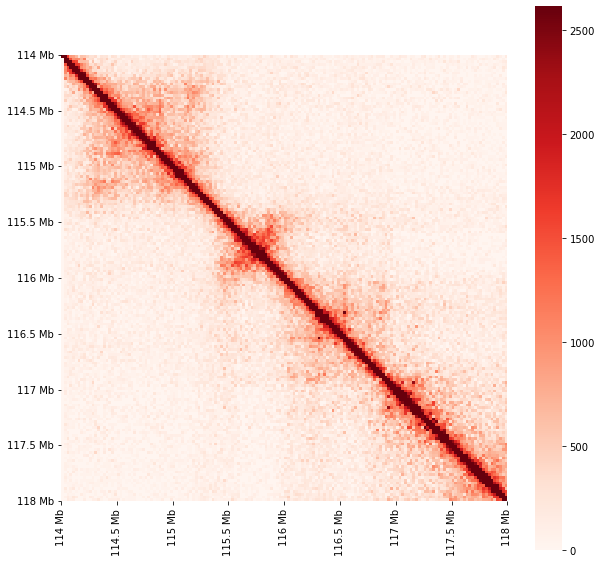

In [6]:
visualize2(114000000, 118000000, strata)

## chr10:114-118 Mb - Vertical

In [7]:
vmat = strata2vertical(strata)
print(vmat.shape)
st, ed = 114000000 // 25000, 118000000 // 25000
sub_vmat = vmat[st:ed, :]
print(sub_vmat.shape)

(5422, 200)
(160, 200)


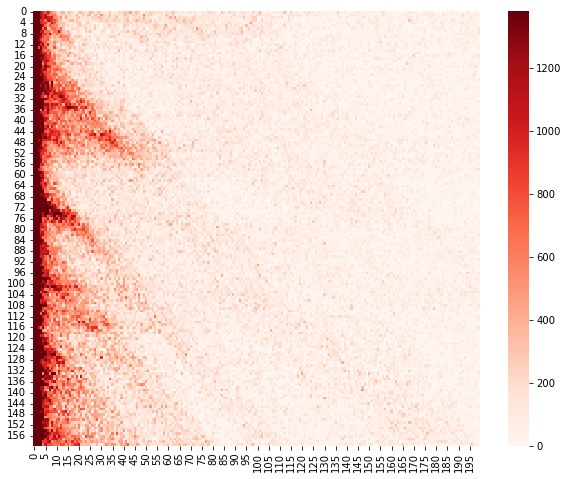

In [8]:
plt.figure(figsize=(10, 8))
sns.heatmap(sub_vmat, cmap='Reds', vmin=0, vmax=np.quantile(sub_vmat, 0.98))
plt.show()

## Get Stripe Location and Width

In [9]:
def get_stripe_and_widths_new(mat, nstrata_gap=400, nstrata_blank=10, sigma=12., rel_height=0.3, max_width=5, gabor_freq=0.1, gabor_theta=0):
    """
    From the sparse contact map, generate candidate vertical / horizontal stripes.

    Parameters
    ----------
    mat: np.array
        Contact matrix from "strata2horizontal()" or "strata2vertical()"

    nstrata_gap: int
        Max distance from the diagonal to calculate candidate peaks

    nstrata_blank: int
        Number of strata near the diagonal to blank out to calculate candidate peaks

    sigma: float
        Gaussian filter std

    rel_height: float
        Relative peak height for width calling

    Returns
    ----------
    peaks: dict
        Peak locations and peak widths

    """
    # print(nstrata_gap)
    # print(mat.shape, nstrata_blank, nstrata_gap)
    # print(np.sum(mat))
    theta = gabor_theta*np.pi/2
    kernel = gabor_kernel(gabor_freq, theta=theta)
    mat = power(mat, kernel)
    mat_sum = np.sum(mat[:, nstrata_blank:nstrata_gap], axis=1)
    # np.save('K562.npy', mat_sum)
    s_filtered = gaussian_filter1d(mat_sum, sigma=sigma)
    s_max = signal.argrelmax(s_filtered)[0]
    # np.savetxt('s_max.txt', s_max)
    s_widths = signal.peak_widths(s_filtered, peaks=s_max, rel_height=rel_height)[0]
    s_widths[s_widths > max_width] = max_width
    
    peaks = {i: j for (i, j) in zip(s_max, s_widths)}
    
    st, ed = 114000000 // 25000, 118000000 // 25000
    plt.figure(figsize=(9, 15))
    plt.subplot(311)
    orig_mat = vmat[st:ed, :nstrata_gap].T
    sns.heatmap(orig_mat, cmap='Reds', vmin=0, vmax=np.quantile(orig_mat, 0.98), cbar=False)
    plt.subplot(312)
    temp_mat = deepcopy(mat[st:ed, :nstrata_gap])
    temp_mat[:, :nstrata_blank] = 0
    temp_mat = temp_mat.T
    sns.heatmap(temp_mat, cmap='Reds', vmin=0, vmax=np.quantile(temp_mat, 0.98), cbar=False)
    plt.subplot(313)
    plt.plot(np.arange(ed - st), mat_sum[st:ed])
    plt.plot(np.arange(ed - st), s_filtered[st:ed])
    
    width = np.zeros((ed - st,))
    for k in peaks:
        if k >= ed or k < st:
            continue
        plt.axvline(k - st, color='red')
        w = int(round(peaks[k]))
        peak_st, peak_ed = max(0, k - st - w // 2), min(ed - st, k - st + w // 2 + 1)
        # print(peak_st, peak_ed, k, st, signals[0][k - st])
        width[peak_st: peak_ed] = mat_sum[k]
    
    plt.fill_between(np.arange(ed - st), 0, width, alpha=0.3, color='gray')
    plt.xlim([0, ed - st])
    plt.show()
    plt.close()
    
    return peaks

In [10]:
def get_stripe_and_widths_noGabor(mat, nstrata_gap=400, nstrata_blank=10, sigma=12., rel_height=0.3, max_width=5, gabor_freq=0.1, gabor_theta=0):
    """
    From the sparse contact map, generate candidate vertical / horizontal stripes.

    Parameters
    ----------
    mat: np.array
        Contact matrix from "strata2horizontal()" or "strata2vertical()"

    nstrata_gap: int
        Max distance from the diagonal to calculate candidate peaks

    nstrata_blank: int
        Number of strata near the diagonal to blank out to calculate candidate peaks

    sigma: float
        Gaussian filter std

    rel_height: float
        Relative peak height for width calling

    Returns
    ----------
    peaks: dict
        Peak locations and peak widths

    """
    # print(nstrata_gap)
#     theta = gabor_theta*np.pi/2
#     kernel = gabor_kernel(gabor_freq, theta=theta)
#     mat = power(mat, kernel)
    mat_sum = np.sum(mat[:, nstrata_blank:nstrata_gap], axis=1)
    # np.save('K562.npy', mat_sum)
    s_filtered = gaussian_filter1d(mat_sum, sigma=sigma)
    s_max = signal.argrelmax(s_filtered)[0]
    # np.savetxt('s_max.txt', s_max)
    s_widths = signal.peak_widths(s_filtered, peaks=s_max, rel_height=rel_height)[0]
    s_widths[s_widths > max_width] = max_width
    
    peaks = {i: j for (i, j) in zip(s_max, s_widths)}
    
    st, ed = 114000000 // 25000, 118000000 // 25000
    plt.figure(figsize=(9, 10))
    plt.subplot(211)
    temp_mat = deepcopy(mat[st:ed, :nstrata_gap])
    temp_mat[:, :nstrata_blank] = 0
    temp_mat = temp_mat.T
    sns.heatmap(temp_mat, cmap='Reds', vmin=0, vmax=np.quantile(temp_mat, 0.98), cbar=False)
    plt.subplot(212)
    plt.plot(np.arange(ed - st), mat_sum[st:ed])
    plt.plot(np.arange(ed - st), s_filtered[st:ed])
    
    width = np.zeros((ed - st,))
    for k in peaks:
        if k >= ed or k < st:
            continue
        plt.axvline(k - st, color='red')
        w = int(round(peaks[k]))
        peak_st, peak_ed = max(0, k - st - w // 2), min(ed - st, k - st + w // 2 + 1)
        # print(peak_st, peak_ed, k, st, signals[0][k - st])
        width[peak_st: peak_ed] = mat_sum[k]
    
    plt.fill_between(np.arange(ed - st), 0, width, alpha=0.3, color='gray')
    plt.xlim([0, ed - st])
    plt.show()
    plt.close()
    
    return peaks

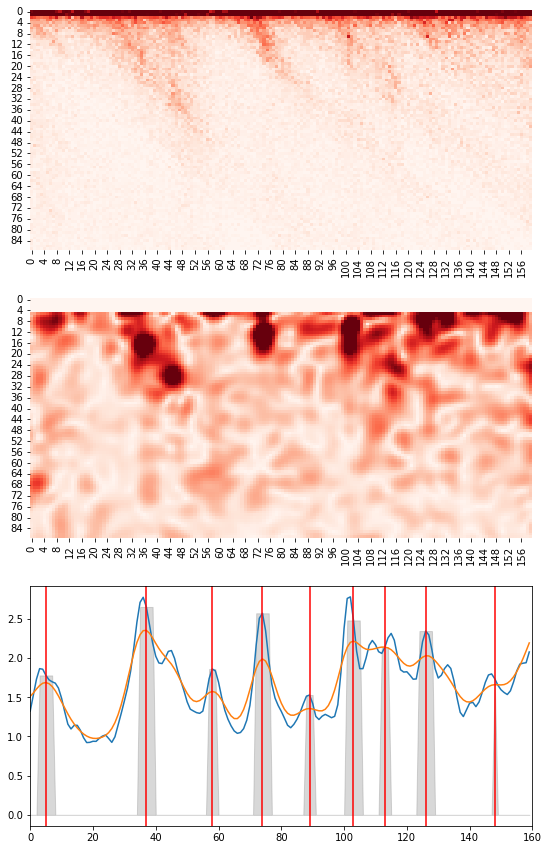

In [11]:
max_range = 2000000
min_length = 200000
resolution = 25000
nstrata_blank = 5

v_Peaks = get_stripe_and_widths_new(
    vmat, (max_range + min_length) // resolution, nstrata_blank,
    sigma=3, rel_height=0.3, max_width=5,
    gabor_freq=0.2, gabor_theta=1
)

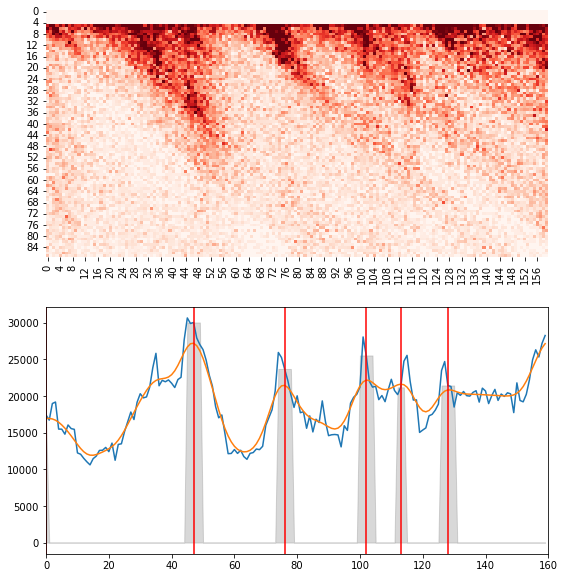

In [12]:
max_range = 2000000
min_length = 200000
resolution = 25000
nstrata_blank = 5

v_Peaks = get_stripe_and_widths_noGabor(
    vmat, (max_range + min_length) // resolution, nstrata_blank,
    sigma=3, rel_height=0.3, max_width=5,
    gabor_freq=0.2, gabor_theta=1
)

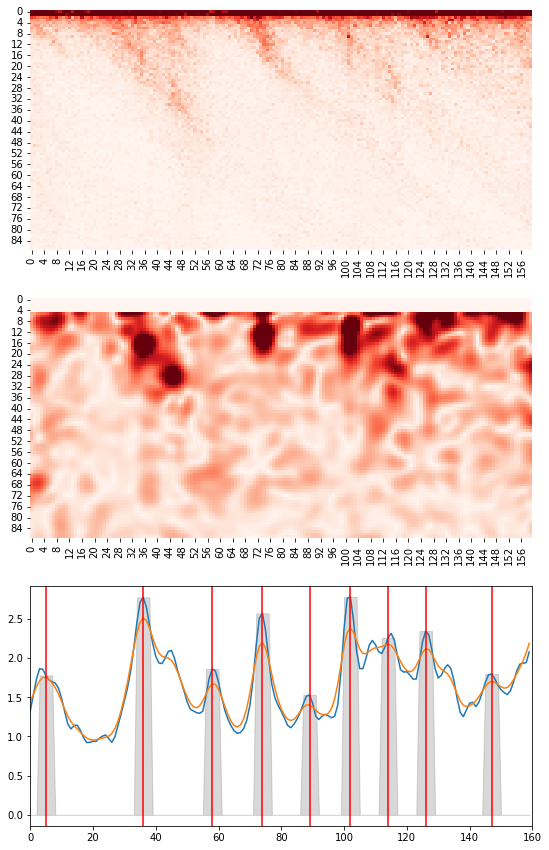

In [13]:
max_range = 2000000
min_length = 200000
resolution = 25000
nstrata_blank = 5

v_Peaks = get_stripe_and_widths_new(
    vmat, (max_range + min_length) // resolution, nstrata_blank,
    sigma=2, rel_height=1, max_width=5,
    gabor_freq=0.2, gabor_theta=1
)

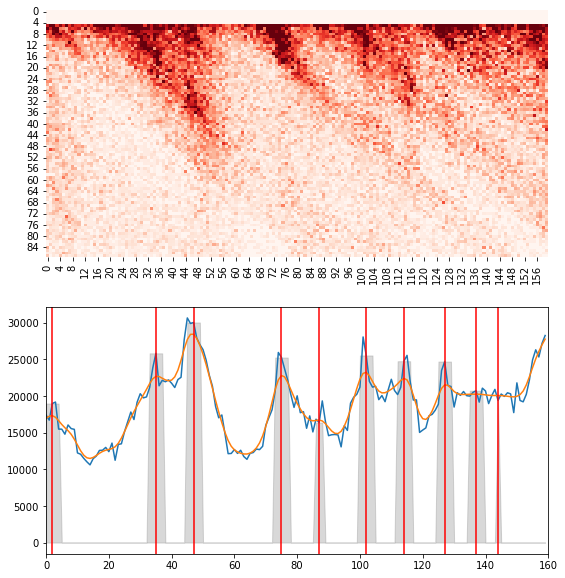

In [16]:
max_range = 2000000
min_length = 200000
resolution = 25000
nstrata_blank = 5

v_Peaks = get_stripe_and_widths_noGabor(
    vmat, (max_range + min_length) // resolution, nstrata_blank,
    sigma=2, rel_height=1, max_width=5
)

In [20]:
st, ed = 114000000 // 25000, 118000000 // 25000
for k, v in v_Peaks.items():
    if st <= k < ed:
        print(k, k - st, v)

4562 2 3.0
4595 35 3.0
4607 47 3.0
4635 75 3.0
4647 87 2.8572323560911173
4662 102 3.0
4674 114 3.0
4687 127 3.0
4697 137 3.0
4704 144 1.0414975453832085


## Stats Test

In [31]:
# vmat must be loaded
def check_stats_result(location, width, pval=0.10, window=10):
    sub_mat = vmat[pos - 50: pos + 51, :max_range // resolution]
    enrichment_score, _obs, _exp = enrichment_score2(
        vmat, pos, width, norm_factors,
        distance_range=(0, max_range // resolution), window_size=window,
        stats_test_log=({}, {})
    )
    head, tail, _max = find_max_slice(enrichment_score + np.log10(pval))

    plt.figure(figsize=(9, 9))
    plt.subplot(311)
    sns.heatmap(sub_mat, square=False, cmap='Reds', vmax=np.quantile(sub_mat, 0.98), vmin=0, cbar=False)
    plt.subplot(312)
    plt.plot(np.arange(len(enrichment_score)), _obs, label='Observed')
    plt.plot(np.arange(len(enrichment_score)), _exp, label='Neighbor')
    plt.legend()
    plt.subplot(313)
    plt.plot(np.arange(len(enrichment_score)), enrichment_score, label='P value')
    plt.plot(np.arange(head, tail), enrichment_score[head: tail], c='black')
    plt.axhline(-np.log10(pval), c='red', label='Threshold')
    plt.legend()
    plt.xlim([0, sub_mat.shape[1]])
    plt.show()

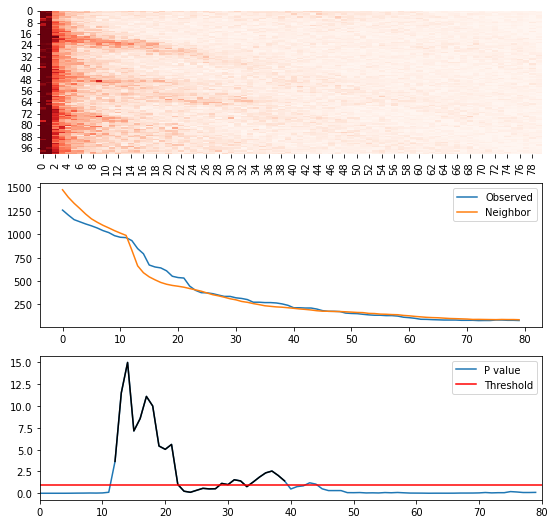

In [32]:
# The stripe we want!
pos = 4662
width = 2
check_stats_result(pos, width, pval=0.10, window=10)

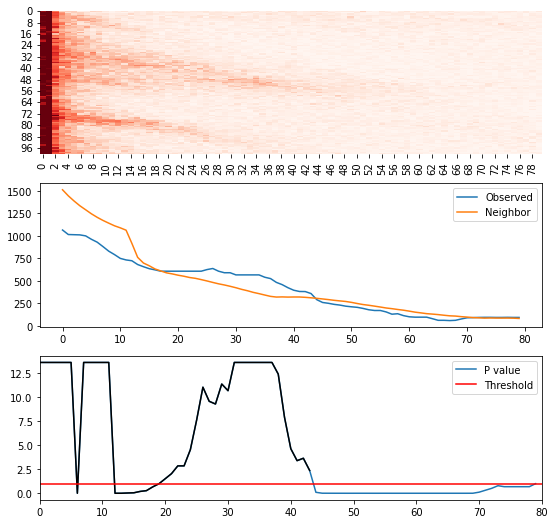

In [33]:
# This might be a stripe
pos = 4607
width = 2
check_stats_result(pos, width, pval=0.10, window=10)

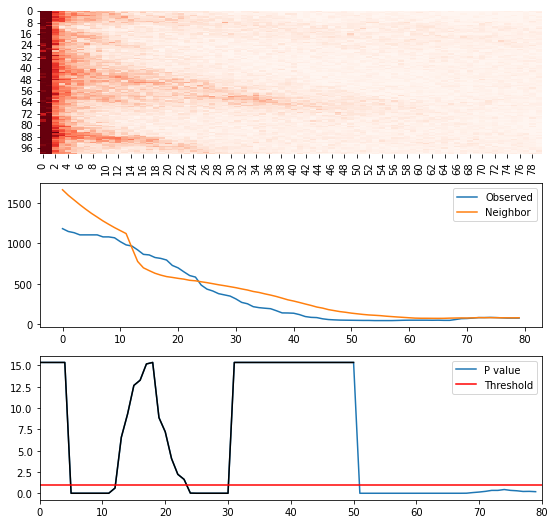

In [34]:
# This might be a stripe
pos = 4595
width = 2
check_stats_result(pos, width, pval=0.10, window=10)

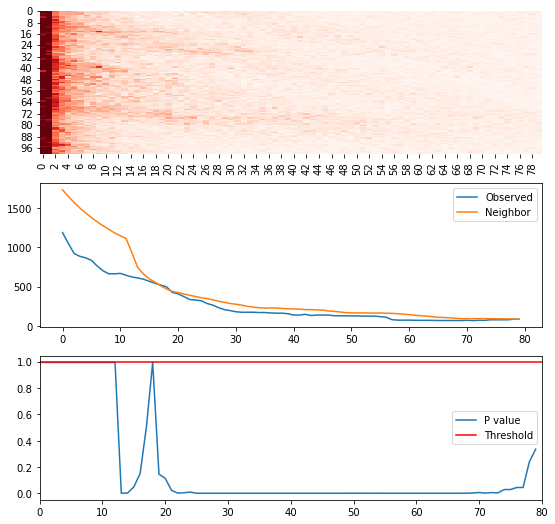

In [35]:
# A clear false positive!
pos = 4697
width = 2
check_stats_result(pos, width, pval=0.10, window=10)

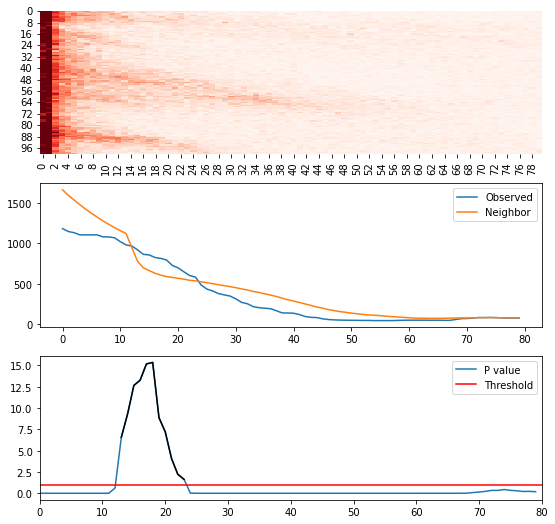

In [65]:
from AVL_tree import AVLTree

def enrichment_score3(mat, idx, line_width, norm_factors, distance_range=(20, 40), window_size=10,
                      stats_test_log=({}, {})):
    """
    Calculate the enrichment score of a stripe given its location, width and the contact matrix

    Parameters:
    ----------
    mat: np.array (2D)
        Contact matrix generated with strata2horizontal() or strata2vertical()

    idx: int
        The location (index) of the candidate stripe

    line_width: int
        Stripe width (# of bins)

    norm_factors: np.array (1D)
        The vector of normalization factors of the contact map.

    distance_range: tuple
        The distance range (# of bins) for the diagonal for calculating the scores

    window_size: int
        Window size (# of bins)

    stats_test_log: tuple of dict
        Previous log for accelerating statistical tests


    Returns
    ----------
    new_mat: np.array (1D)
        The enrichment score of each pixel along the candidate stripe

    """
    _calculated_values, _poisson_stats = stats_test_log

    half = int(line_width // 2)
    x1, x2 = idx - half, idx - half + line_width
    if x1 == x2:
        x2 += 1

    new_mat = np.zeros((distance_range[1] - distance_range[0],))
    _exps, _obss = np.zeros((distance_range[1] - distance_range[0],)), np.zeros((distance_range[1] - distance_range[0],))
    for j in range(distance_range[0], distance_range[1]):
        y = j - distance_range[0]
        _min_temp = subsetNpMatrix(mat, (x1, x2), (j - window_size - half, j + window_size + half + 1))
        line_min = np.median([_min_temp])
        # print(_min_temp, line_min)
        _inner_neighbor = subsetNpMatrix(mat, (idx - half - window_size, x1),
                                         (j - window_size - half, j + window_size + half + 1))
        _outer_neighbor = subsetNpMatrix(mat, (x2 + 1, idx + half + window_size + 1),
                                         (j - window_size - half, j + window_size + half + 1))

        if _outer_neighbor.size == 0 or _inner_neighbor.size == 0:
            continue
            
        neighbor_mean = max(np.mean(_inner_neighbor), np.mean(_outer_neighbor))

        # There should be a lower bound for the expected value,
        # otherwise situations like (exp=0.01 and obs=0.02) would also be significant
        # Currently we can set this to 0 until KR norm factors can be loaded
        lower_b = 1 / norm_factors[idx]  # This should be (1 / KR_norm_factors) if we refer to JuiceTools HICCUPS
        _exp = max(neighbor_mean, lower_b)
        _obs = int(line_min)  # the same as floor function when line_min > 0
        _exps[y] = _exp
        _obss[y] = _obs

        # _calculated_values: store all calculated exp-obs pairs in dictionary, in which keys are obs since
        #     they are always integers. Each _calculated_values[obs] is a binary tree for quick searching,
        #     and each tree leaf is a exp value corresponding to the obs value. Since exp values are float,
        #     there is also an integer index attached for searching the exp-obs in dictionary _poisson_stats
        #     (float cannot be dict keys).
        # _poisson_stats: record all calculated result in a dict. It should be
        #     _poisson_stats[(_exp, _obs)] = -log10(p). But _exp is a float and cannot be a dict key, we give
        #     each _exp a unique index and use the index.
        # stats_log: record all p value calculation. Just for benchmarking. Delete this when publishing.

        # global _calculated_values, _poisson_stats  # , stats_log
        tolerance = 0.02
        
#         if 30 < y < 52:
#             verbose = 1
#             print(y, _exp, _obs)
#         else:
#             verbose = 0
        verbose = 0

        # check if obs is a value calculated before
        if _obs in _calculated_values:
            # Find the nearest _exp values which were calculated before
            # One larger, one smaller
            (_upper, _lower) = _calculated_values[_obs].search(_exp)
            if verbose:
                print('In', _obs, _upper, _lower)
            # If _upper is close enough to _exp, directly use the p value from (_upper-_obs) pair
            if _upper is not None and (_upper.key - _exp) < tolerance * _exp:
                _exp = _upper.key
                _exp_idx = _upper.val  # The integer index for _upper (float cannot be dict keys!)
                mlog_p_val = _poisson_stats[(_exp_idx, _obs)]
                if verbose:
                    print(' In', _exp, _exp_idx, mlog_p_val)
            else:
                # Else, calculate p value for _obs-_exp pair and store them in _calculated_values and _poisson_stats
                _exp_idx = _calculated_values[_obs].insert(_exp)  # insert to the binary tree and return an index
                Poiss = poisson(_exp)
                p_val = 1 - Poiss.cdf(_obs)
                if p_val <= 0: # Some p values are too small, -log(0) will return an error, so we use -1 to temporarily replace
                    mlog_p_val = -1
                elif p_val > 1:
                    mlog_p_val = 0
                else:
                    mlog_p_val = - np.log10(p_val)
                _poisson_stats[(_exp_idx, _obs)] = mlog_p_val
                # stats_log.append([_exp, _obs, mlog_p_val])
                if verbose:
                    print(' Not', mlog_p_val)
        else:  # If _obs is not used before, generate a new binary tree _calculated_values[_obs]
            _calculated_values[_obs] = AVLTree()
            _exp_idx = _calculated_values[_obs].insert(_exp)
            # calculate p value for _obs-_exp pair and store them in _calculated_values and _poisson_stats
            Poiss = poisson(_exp)
            p_val = 1 - Poiss.cdf(_obs)
            if p_val <= 0: # Some p values are too small, -log(0) will return an error, so we use -1 to temporarily replace
                mlog_p_val = -1
            elif p_val > 1:
                mlog_p_val = 0
            else:
                mlog_p_val = - np.log10(p_val)
            _poisson_stats[(_exp_idx, _obs)] = mlog_p_val
            # stats_log.append([_exp, _obs, mlog_p_val])
            if verbose:
                print('Not', mlog_p_val, p_val)

        # Store enrichment score in new_mat
        new_mat[y] = mlog_p_val
    new_mat[new_mat < 0] = np.max(new_mat)  # Replace all "-1"s with the largest -log(p)

    return new_mat, _obss, _exps

def check_stats_result2(location, width, pval=0.10, window=10):
    sub_mat = vmat[pos - 50: pos + 51, :max_range // resolution]
    enrichment_score, _obs, _exp = enrichment_score3(
        vmat, pos, width, norm_factors,
        distance_range=(0, max_range // resolution), window_size=window,
        stats_test_log=({}, {})
    )
    head, tail, _max = find_max_slice(enrichment_score + np.log10(pval))

    plt.figure(figsize=(9, 9))
    plt.subplot(311)
    sns.heatmap(sub_mat, square=False, cmap='Reds', vmax=np.quantile(sub_mat, 0.98), vmin=0, cbar=False)
    plt.subplot(312)
    plt.plot(np.arange(len(enrichment_score)), _obs, label='Observed')
    plt.plot(np.arange(len(enrichment_score)), _exp, label='Neighbor')
    plt.legend()
    plt.subplot(313)
    plt.plot(np.arange(len(enrichment_score)), enrichment_score, label='P value')
    plt.plot(np.arange(head, tail), enrichment_score[head: tail], c='black')
    plt.axhline(-np.log10(pval), c='red', label='Threshold')
    plt.legend()
    plt.xlim([0, sub_mat.shape[1]])
    plt.show()

pos = 4595
width = 2
check_stats_result2(pos, width, pval=0.10, window=10)

## Use the smoothed contact map?

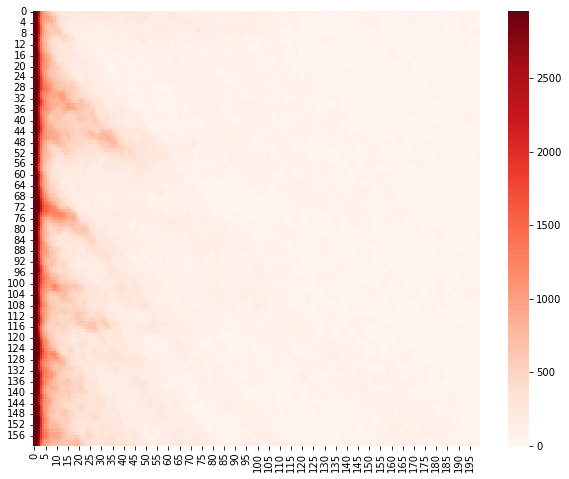

In [59]:
nstrata_blank = 3
vmat_gaussian = gaussian_filter(vmat, sigma=1)
# vmat_gaussian[:, :nstrata_blank] = 0
st, ed = 114000000 // 25000, 118000000 // 25000
sub_vmat = vmat_gaussian[st:ed, :]
plt.figure(figsize=(10, 8))
sns.heatmap(sub_vmat, cmap='Reds', vmin=0, vmax=np.quantile(sub_vmat, 0.99))
plt.show()

In [66]:
def check_stats_result2(location, width, pval=0.10, window=10):
    sub_mat = vmat_gaussian[pos - 50: pos + 51, :max_range // resolution]
    enrichment_score, _obs, _exp = enrichment_score3(
        vmat_gaussian, pos, width, norm_factors,
        distance_range=(0, max_range // resolution), window_size=window,
        stats_test_log=({}, {})
    )
    head, tail, _max = find_max_slice(enrichment_score + np.log10(pval))

    plt.figure(figsize=(9, 9))
    plt.subplot(311)
    sns.heatmap(sub_mat, square=False, cmap='Reds', vmax=np.quantile(sub_mat, 0.98), vmin=0, cbar=False)
    plt.subplot(312)
    plt.plot(np.arange(len(enrichment_score)), _obs, label='Observed')
    plt.plot(np.arange(len(enrichment_score)), _exp, label='Neighbor')
    plt.xlim([0, sub_mat.shape[1]])
    plt.legend()
    plt.subplot(313)
    plt.plot(np.arange(len(enrichment_score)), enrichment_score, label='P value')
    plt.plot(np.arange(head, tail), enrichment_score[head: tail], c='black')
    plt.axhline(-np.log10(pval), c='red', label='Threshold')
    plt.legend()
    plt.xlim([0, sub_mat.shape[1]])
    plt.show()

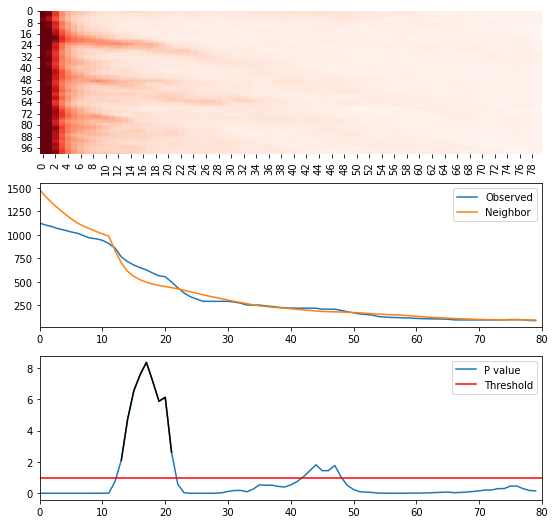

In [67]:
# The stripe we want!
pos = 4662
width = 2
check_stats_result2(pos, width, pval=0.10, window=10)

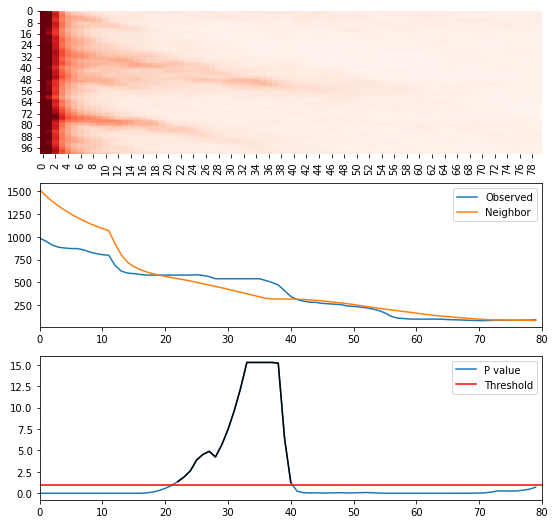

In [68]:
# This might be a stripe
pos = 4607
width = 2
check_stats_result2(pos, width, pval=0.10, window=10)

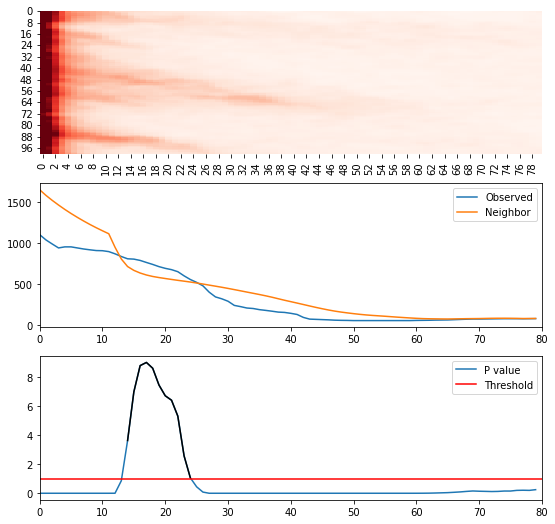

In [69]:
# This might be a stripe
pos = 4595
width = 2
check_stats_result2(pos, width, pval=0.10, window=10)

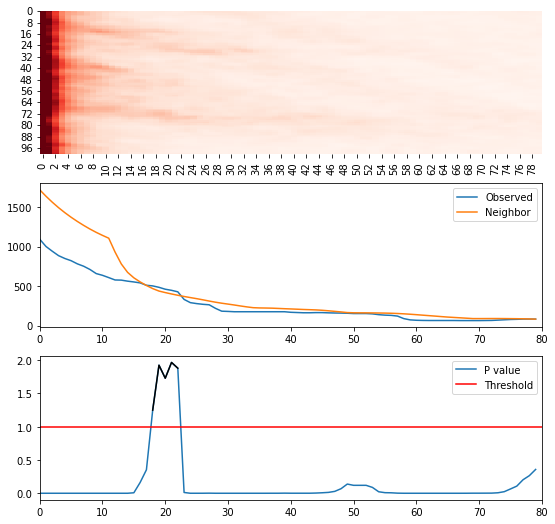

In [70]:
# This is not a stripe
pos = 4697
width = 2
check_stats_result2(pos, width, pval=0.10, window=10)